#Visual Transofrmer (ViT) PyTorch implementation for Cifar 100 dataset

Configure parameters

In [1]:
# Parameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001
image_size = 64
heads = 4
image_channels = 3
patch_size=8
embedding_dims = 128

epochs = 10

crop_size = 40 # Data augmentation crop size

In [2]:
!pip install -q torchinfo
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.4 MB/s eta 0:00:00


In [3]:
import sys
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torch import from_numpy, rand, cat, reshape, cuda, optim, utils, sum, argmax
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchinfo import summary
from torchmetrics import Accuracy
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from tqdm.auto import tqdm

Download dataset and configure data loader

In [4]:
original_dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 77814411.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Images will be used as resized. Everyt data augmentation will comprehend initial resize.

Apply data augmentation to upsampled dataset

In [5]:
# Dataset with upsample transform
upsample_transform = transforms.Compose(
                                        [transforms.Resize(image_size),
                                         transforms.ToTensor()])
upsampled_dataset = CIFAR10(root='./data', train=True, download=True, transform=upsample_transform)

# Define the new transformations
transform_ops = [[transforms.RandomHorizontalFlip(p=1)], # Flip all images
                 [transforms.RandomRotation(degrees=15)], # Rotate between -15 and 15 degrees
                 [transforms.RandomCrop(size=crop_size), transforms.Resize(image_size)]]

# Create a list of transforms. Each of them includes upsample
transformsations = []
for op in transform_ops:
    transformsations.append(transforms.Compose([transforms.Resize(image_size),
                                                *op,
                                                transforms.ToTensor()]))

# Create a list of transformed datasets
transformed_datasets = []
for t in transformsations:
    transformed_datasets.append(CIFAR10(root='./data', train=True, download=True, transform=t))

# Concatenate the transformed datasets, including the original one
datasets = [upsampled_dataset] + transformed_datasets
combined_dataset = ConcatDataset(datasets)

# Create a dataloader for the concatenate datasets
subset = Subset(combined_dataset, list(np.linspace(0, 19999, 20000).astype(int)))

train_set, val_set = utils.data.random_split(subset, [18000,2000])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Provide an example of upsampling and data augmentation

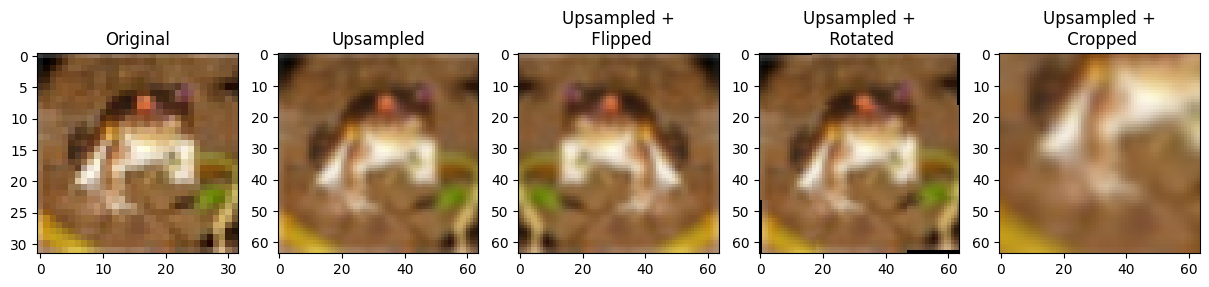

In [6]:
example_images = []
f, ax = plt.subplots(1, 5, figsize=(15, 15))

subset_indices = [0]

titles = ["Original",
          "Upsampled",
          "Upsampled +\n Flipped",
          "Upsampled +\n Rotated",
          "Upsampled +\n Cropped"]

for n, (dataset, title) in enumerate(zip([original_dataset] + datasets, titles)):
  subset_upsampled = Subset(dataset, subset_indices)
  loader_subset = DataLoader(subset_upsampled, batch_size=1, num_workers=0, shuffle=False)
  for data in loader_subset:
    if n != 0:
      example_images.append(data[0])

    ax[n].imshow(np.squeeze(data[0]).permute(1, 2, 0))
    ax[n].set_title(title)
    plt.show


In [7]:
class Patchify(nn.Module):
    def __init__(self, patch_size=8):
        super().__init__()
        self.p = patch_size
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x -> B c h w
        bs, c, h, w = x.shape

        x = self.unfold(x)
        # x -> B (c*p*p) L

        # Reshaping into the shape we want
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        return a

In [8]:
patch = Patchify(patch_size)
image = example_images[0]
p = patch(image)
p = p.squeeze() # to remove the batch dimension for plotting

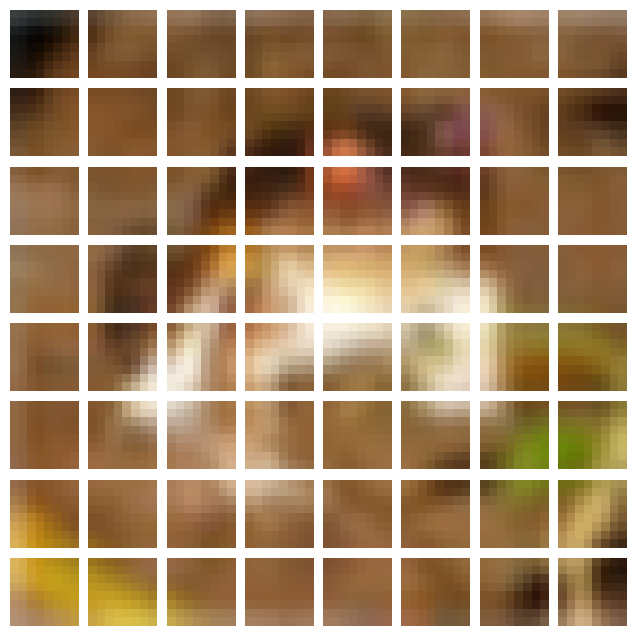

In [9]:
def plot_patches(tensor):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.1)

    for i, ax in enumerate(grid):
        patch = tensor[i].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

plot_patches(p)

Patches encoding

In [10]:
embedding_dims = patch_size**2 * image_channels
num_of_patches = int((image_size**2) / patch_size**2)  # Suppose the image is square

In [11]:
class PatchEncoder(nn.Module):
    def __init__(self, image_channels=3, patch_size=8, image_size=64, batch_size=64):
        super().__init__()

        embedding_dim = patch_size**2 * image_channels
        num_of_patches = int((image_size / patch_size)**2)  # Suppose the image is square

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = image_channels
        self.flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
        self.patchify = Patchify(patch_size)
        self.class_token_embeddings = nn.Parameter(rand((batch_size, 1, embedding_dims), requires_grad  = True))
        self.position_embeddings = nn.Parameter(rand((1, num_of_patches+1, embedding_dims), requires_grad = True ))

    def forward(self, x):
        # print("self.class_token_embeddings.shape = ", self.class_token_embeddings.shape)
        patches = self.patchify(x)
        # print("patches.shape = ", patches.shape)
        flattened = self.flatten_layer(patches)
        # print("flattened.shape = ", flattened.shape)
        token_embeddings_cat_flatten = cat((self.class_token_embeddings, flattened), dim=1)
        # print("token_embeddings_cat_flatten.shape = ", token_embeddings_cat_flatten.shape)
        return token_embeddings_cat_flatten + self.position_embeddings

In [12]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 192,
               num_heads = 12,
               attn_dropout = 0.0
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

Create MutliLayer Perception model

In [13]:
class MutliLayerPerceptron(nn.Module):
  def __init__(self, embedding_dims=192, mlp_size=3072, mlp_dropout=0.1):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

Create Transformer block

In [14]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MutliLayerPerceptron(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

Create vision transformer

In [15]:
class ViT(nn.Module):
  def __init__(self, img_size = 64,
               in_channels = 3,
               patch_size = 8,
               embedding_dims = 192,
               num_transformer_layers = 12,
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = len(original_dataset.classes)):
    super().__init__()

    self.patch_embedding_layer = PatchEncoder(image_channels = in_channels,
                                              patch_size=patch_size,
                                              image_size=image_size)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [16]:
#We check whether cuda is available and choose device accordingly
if cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [17]:
visual_transformer = ViT().to(device)

optimizer = optim.Adam(visual_transformer.parameters())
criterion = nn.CrossEntropyLoss()

Training

In [ ]:
classes = original_dataset.classes
accuracy_fn = Accuracy(task="multiclass", num_classes=len(classes))
epoch_loss, epoch_acc = [], []
val_epoch_loss, val_epoch_acc = [], []
for epoch in range(epochs):

    train_loss, train_acc = 0.0, 0.0
    val_loss, val_acc = 0.0, 0.0
    # Training data
    for i, data in enumerate(tqdm(train_loader, desc=f'epoch: {epoch}\n')):
        # Check that the number of images equals the batch size
        if data[0].shape[0] != batch_size:
            continue
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = visual_transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Save loss and accuracy
        train_loss += loss.item()
        accuracy = sum(argmax(outputs, dim=1) == labels).item()
        train_acc += accuracy

        accuracy_fn = Accuracy(task="multiclass", num_classes=len(classes))
        sys.stdout.write('\r' + 'train loss = ' + str(train_loss/(i+1)) + ' train acc = ' + str(((train_acc/(i+1))/batch_size) * 100) + '%')
        sys.stdout.flush()
        if i == int(np.floor(len(train_set)/batch_size)-1):
          epoch_loss.append(train_loss/(i+1))
          epoch_acc.append(((train_acc/(i+1))/batch_size) * 100)

    sys.stdout.write('\n')
    # Validation data
    for i, data in enumerate(val_loader):
        # Check that the number of images equals the batch size
        if data[0].shape[0] != batch_size:
            continue
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward
        outputs = visual_transformer(inputs)

        # Save loss
        val_loss += criterion(outputs, labels).item()
        accuracy = sum(argmax(outputs, dim=1) == labels).item()
        val_acc += accuracy
        sys.stdout.write('\r' + 'validation loss = ' + str(val_loss/(i+1)) + ' validation acc = ' + str(((val_acc/(i+1))/batch_size) * 100) + '%')
        sys.stdout.flush()
        if i == int(np.floor(len(val_set)/batch_size)-1):
          val_epoch_loss.append(val_loss/(i+1))
          val_epoch_acc.append(((val_acc/(i+1))/batch_size) * 100)


print('Finished Training')

epoch: 0
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.8276952620475524 validation acc = 28.931451612903224

epoch: 1
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.7071560775080035 validation acc = 35.131048387096776

epoch: 2
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.6177242455943939 validation acc = 38.40725806451613

epoch: 3
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.5539656569880824 validation acc = 42.54032258064516

epoch: 4
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.5411220289045764 validation acc = 44.002016129032256

epoch: 5
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.5279891798573155 validation acc = 44.707661290322584

epoch: 6
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.4566483882165724 validation acc = 48.63911290322581

epoch: 7
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.4524429844271751 validation acc = 46.975806451612904

epoch: 8
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.4674397630076255 validation acc = 46.92540322580645

epoch: 9
:   0%|          | 0/282 [00:00<?, ?it/s]

validation loss = 1.4483400929358698 validation acc = 47.983870967741936Finished Training


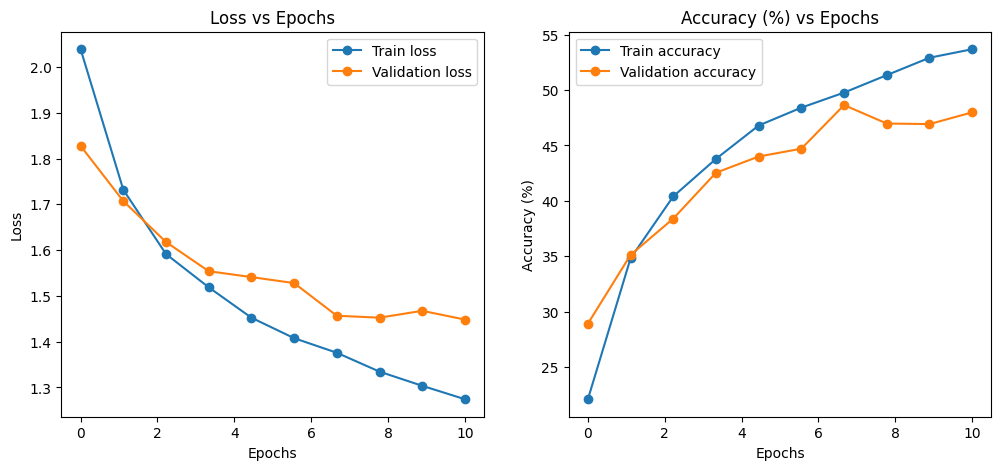

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(np.linspace(0, num_epochs, num_epochs), epoch_loss[:num_epochs], '-o',  label="Train loss")
ax1.plot(np.linspace(0, num_epochs, num_epochs), val_epoch_loss[:num_epochs], '-o', label="Validation loss")
ax1.set_title("Loss vs Epochs")
ax1.set(xlabel="Epochs", ylabel="Loss")
ax1.legend()


ax2.plot(np.linspace(0, num_epochs, num_epochs), epoch_acc[:num_epochs], '-o',  label="Train accuracy")
ax2.plot(np.linspace(0, num_epochs, num_epochs), val_epoch_acc[:num_epochs], '-o', label="Validation accuracy")
ax2.set_title("Accuracy (%) vs Epochs")
ax2.set(xlabel="Epochs", ylabel="Accuracy (%)")
ax2.legend()
plt.show()

Visualize the model

In [34]:
!pip install -q torchviz

In [39]:
for data in train_loader:
    input_data = data[0].to(device)
    break

output = visual_transformer(input_data)

from torchviz import make_dot

make_dot(output).render("visual_transformer", format="png")

'visual_transformer.png'